# settings

In [ ]:
import sys
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import pickle

import scipy.signal as sp

from matplotlib import pyplot as plt
import numpy as np

import os
os.chdir('/content/drive/MyDrive/thesis')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import scipy.signal as sp
import numpy as np
from matplotlib import pyplot as plt

!pip install neurokit2
import neurokit2 as nk

import pywt
import matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.8 MB/s eta 0:00:00


# data visualization

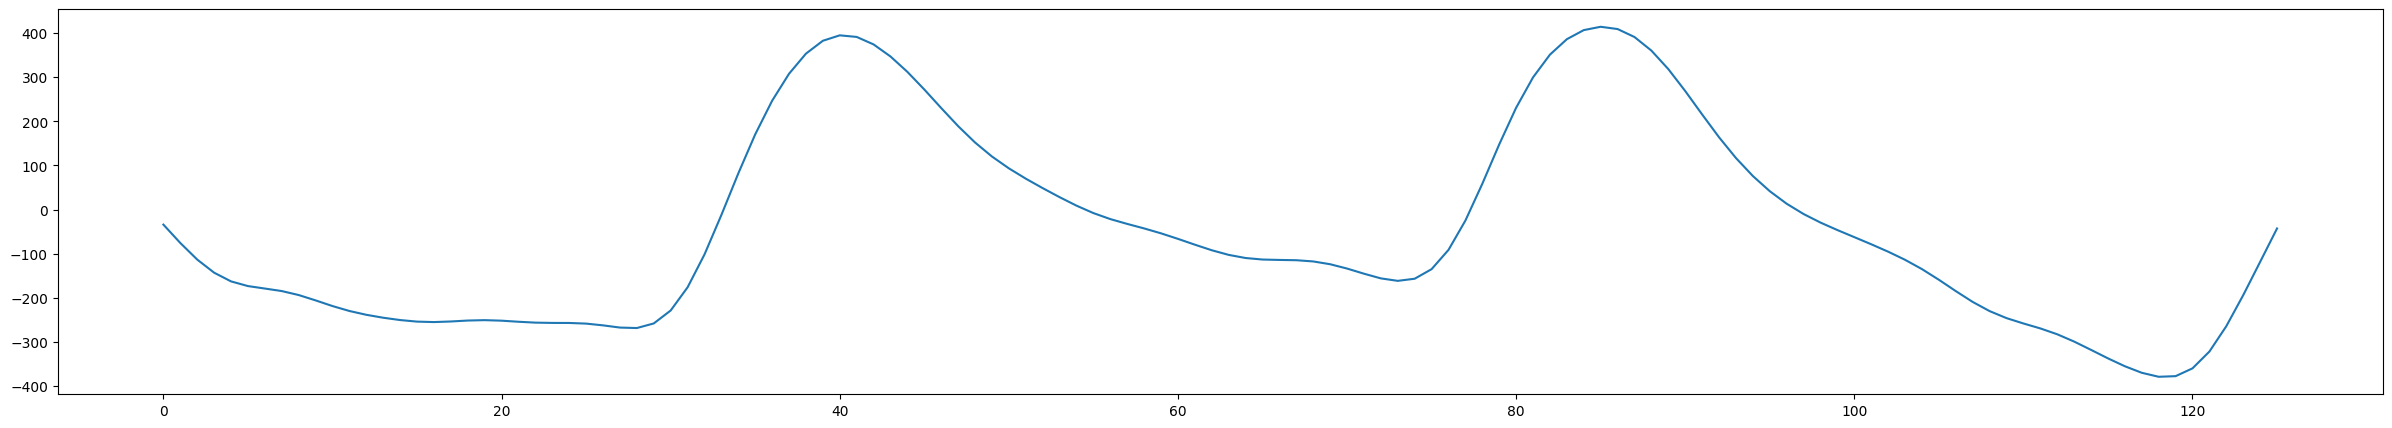

In [ ]:
pickle_filepath = f'raw_ppg/subject_18.pkl'
with open(pickle_filepath, 'rb') as pickle_file:
    ppgs, target, sid = pickle.load(pickle_file)

ppg = nk.ppg_clean(nk.signal_resample(ppgs[0], sampling_rate=1000, desired_sampling_rate=60), sampling_rate=60)
plt.figure(figsize=(30, 5))
plt.plot(ppg)


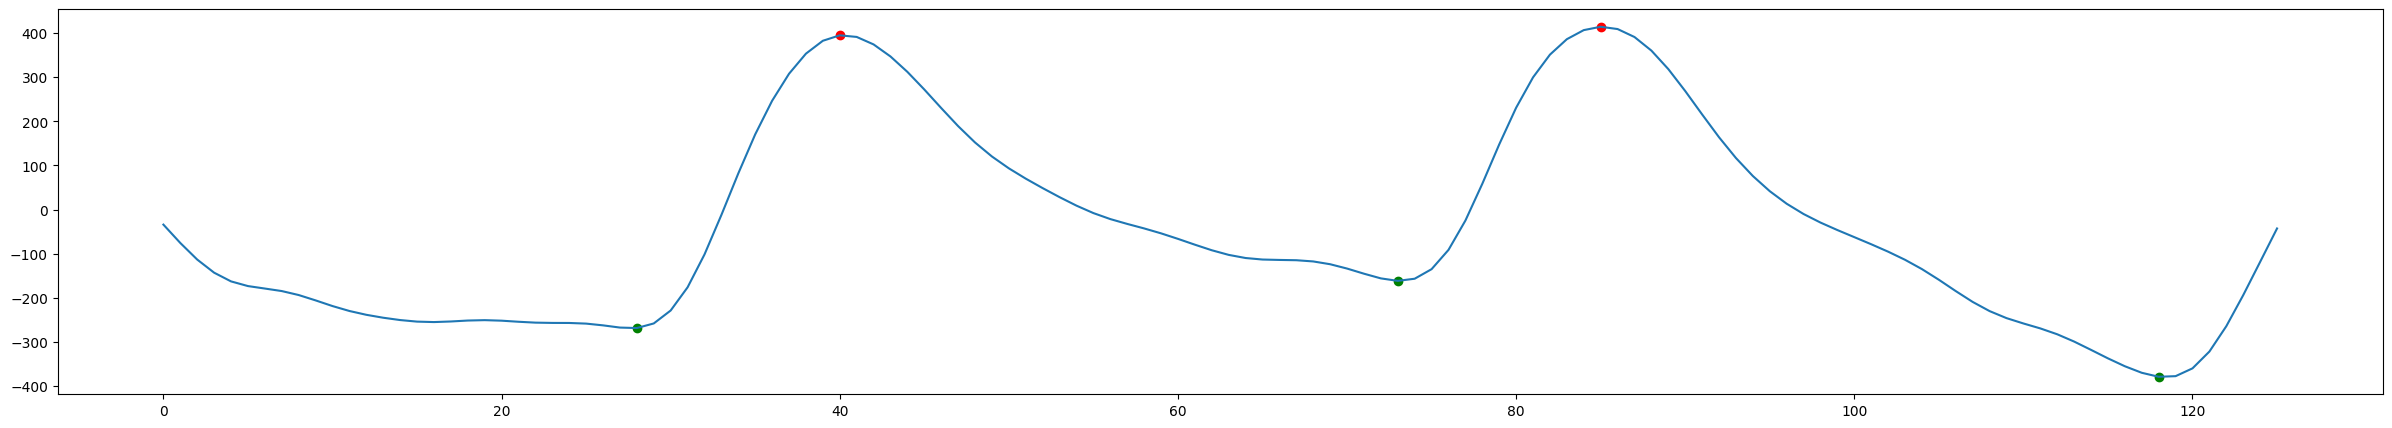

In [ ]:
ons = nk.ppg_findpeaks(-ppg, sampling_rate=60)['PPG_Peaks']
pks = nk.ppg_findpeaks(ppg, sampling_rate=60)['PPG_Peaks']
plt.figure(figsize=(30, 5))
plt.plot(ppg)
plt.scatter(ons, ppg[ons], color='g')
plt.scatter(pks, ppg[pks], color='r')

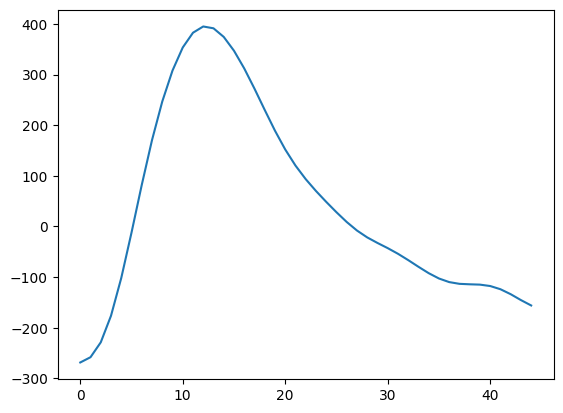

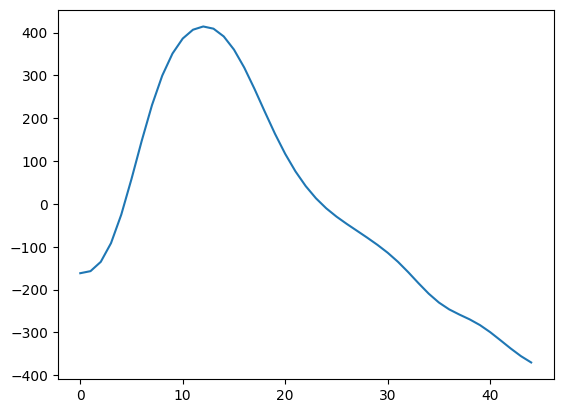

In [ ]:
st = ons[0]
for en in ons[1:]:
    plt.plot(ppg[st:en])
    plt.show()
    st = en


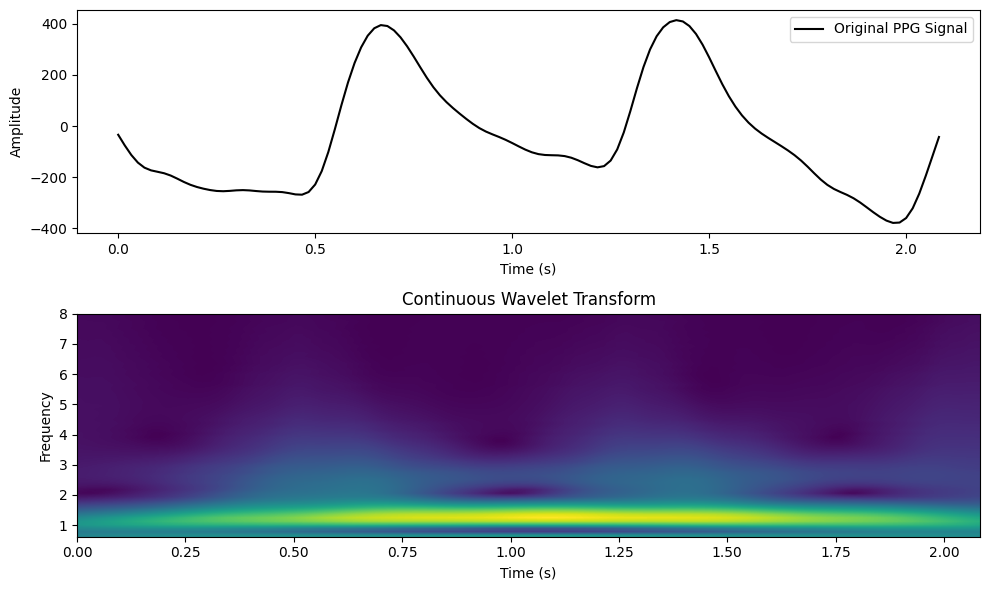

In [ ]:
from scipy import signal

wavelet = 'cgau8'
fs = 125 # частота дискретизации
t = np.arange(0, 2.1, 1 / fs) # временная шкала
dt = 1/125
height = 125
frequencies = np.arange(8, 0.5, -(8 - 0.5) / height) / fs

scale = pywt.frequency2scale(wavelet, frequencies)
widths = scale

cwt_matrix, freqs = pywt.cwt(ppg, widths, wavelet)

# Визуализация
plt.figure(figsize=(10, 6))

# Исходный сигнал
plt.subplot(2, 1, 1)
plt.plot(t, ppg, 'k', label='Original PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Вейвлет-преобразование
plt.subplot(2, 1, 2)
plt.imshow(np.abs(cwt_matrix), extent=[t.min(), t.max(), frequencies[-1]*fs, frequencies[0]*fs], aspect='auto', interpolation='bilinear')
#plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title('Continuous Wavelet Transform')
plt.tight_layout()
plt.show()


In [ ]:
matplotlib.image.imsave(f'scalograms/test.png', np.abs(cwt_matrix))

# dataset creation

## diabetes dataset


In [ ]:
train = pd.read_csv('../job_staff/data/train.csv')
test = pd.read_csv('../job_staff/data/test.csv')
train_sids = train.sid.unique().tolist()
test_sids = test.sid.unique().tolist()

In [ ]:
test_sids[:5], len(test_sids)

([6, 9, 15, 19, 25], 44)

In [ ]:
train_sids[:5], len(train_sids)

([2, 3, 8, 10, 11], 175)

In [ ]:
arr = np.array([1, 2, 3, 4])  # Your array here

# Pad the array to size 64
np.pad(arr, (0, 8 - len(arr)), 'constant', constant_values=(arr[-1]))

array([1, 2, 3, 4, 4, 4, 4, 4])

In [ ]:
from scipy import signal

wavelet = 'cgau8'
fs = 125 # частота дискретизации
height = 64
frequencies = np.arange(10, 0.3, -(10 - 0.3) / height) / fs

scale = pywt.frequency2scale(wavelet, frequencies)
widths = scale

cnt = 0

for f in tqdm(os.listdir('raw_ppg/')):
    with open('raw_ppg/'+f, 'rb') as pickle_file:
        ppgs, _, sid = pickle.load(pickle_file)
    target = df[df.sid == int(sid)].t.tolist()[0]
    for i, ppg in enumerate(ppgs):
        ppg = nk.ppg_clean(nk.signal_resample(ppg, sampling_rate=1000, desired_sampling_rate=fs), sampling_rate=fs)
        ons = nk.ppg_findpeaks(-ppg, sampling_rate=fs)['PPG_Peaks']
        if len(ons) < 2:
            continue
        st = ons[0]
        for j, en in enumerate(ons[1:]):
            wave = ppg[st:en]
            if len(wave) < 64:
                wave = np.pad(wave, (0, 64 - len(wave)), 'constant', constant_values=(wave[-1]))
            cwt_matrix, freqs = pywt.cwt(wave, widths, wavelet)
            if int(sid) in train_sids:
                matplotlib.image.imsave(f'scalograms_leak/train/{target}/{sid}__{i}_{j}.png', np.abs(cwt_matrix))
            else:
                matplotlib.image.imsave(f'scalograms_leak/test/{target}/{sid}__{i}_{j}.png', np.abs(cwt_matrix))
            st = en
            cnt += 1
print(cnt)


100%|██████████| 219/219 [00:21<00:00, 10.17it/s]

813


In [ ]:
df = pd.read_csv('../job_staff/data/df_cleaned.csv')
train = pd.read_csv('../job_staff/data/train.csv')
test = pd.read_csv('../job_staff/data/test.csv')

In [ ]:
train_sids = train.sid.unique().tolist()
test_sids = test.sid.unique().tolist()

In [ ]:
def f(r):
    if r.Hypertension == 'Stage 2 hypertension' or r.Hypertension == 'Stage 1 hypertension':
        return 1
    else:
        return 0

df['hp'] = df.apply(f, axis=1)

In [ ]:
df['t'] = (df.hp + df.target > 0).astype('int')

In [ ]:
df.t.value_counts()

t
0    136
1     83
Name: count, dtype: int64

## blood pressure dataset


In [ ]:
df = df[['systbp', 'diastbp', 'sid', 't']]

In [ ]:
import random
def f1(r):
    return r.systbp + random.choice([-1, 1]) * random.uniform(5, 10)

def f2(r):
    return r.diastbp + random.choice([-1, 1]) * random.uniform(5, 10)

df['syst_estimated'] = df.apply(f1, axis=1)
df['diast_estimated'] = df.apply(f2, axis=1)

In [ ]:
df = df[['sid', 't', 'syst_estimated', 'diast_estimated', 'systbp', 'diastbp']]

In [ ]:
df.query('syst_estimated > 160')

,sid,t,syst_estimated,diast_estimated,systbp,diastbp
0,2,1,166.710608,96.978790,161,89
1,3,1,167.874529,99.767359,160,93
15,21,1,184.886365,94.937929,178,86
19,25,1,168.575515,94.050749,161,89
23,30,1,167.664728,81.076841,173,90
24,31,1,176.104981,108.030846,182,102
35,50,1,162.908382,97.096177,154,88
36,51,1,179.877122,97.154149,173,107
52,83,1,174.305873,74.708978,182,80
55,86,1,177.038138,93.212176,170,87


In [ ]:
df[df.sid.isin(train_sids)].to_csv('targets.csv', index=False)

In [ ]:
for f in os.listdir('raw_ppg'):
    if int(f.split('.')[0].split('_')[1]) in train_sids:
        os.system(f'cp raw_ppg/{f} for_advisor/{f}')